# ADTA 5550: CNN on CIFAR-10: Final Project

## Set Path for Data Folder

In [18]:
 # Put file path as a string here

CIFAR_DIR = 'CIFAR_10_Data/'

## Load Data

In [19]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        cifar_dict = pickle.load(fo, encoding='bytes')
    return cifar_dict

In [20]:
dirs = ['batches.meta','data_batch_1','data_batch_2','data_batch_3','data_batch_4','data_batch_5','test_batch']

all_data = [0,1,2,3,4,5,6]

for i,direc in zip(all_data,dirs):
    all_data[i] = unpickle(CIFAR_DIR+direc)

In [21]:
batch_meta = all_data[0]
data_batch1 = all_data[1]
data_batch2 = all_data[2]
data_batch3 = all_data[3]
data_batch4 = all_data[4]
data_batch5 = all_data[5]
test_batch = all_data[6]

In [22]:
batch_meta

{b'num_cases_per_batch': 10000,
 b'label_names': [b'airplane',
  b'automobile',
  b'bird',
  b'cat',
  b'deer',
  b'dog',
  b'frog',
  b'horse',
  b'ship',
  b'truck'],
 b'num_vis': 3072}

In [23]:
data_batch1.keys()

dict_keys([b'batch_label', b'labels', b'data', b'filenames'])

## Display several examples of single images using matplotlib 

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

In [25]:
X = data_batch1[b"data"] 

In [26]:
X = X.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("uint8")

In [27]:
X[0].max()

255

In [28]:
(X[0]/255).max()

1.0

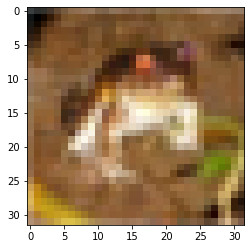

In [29]:
plt.imshow(X[0])

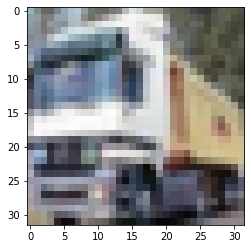

In [30]:
plt.imshow(X[1])

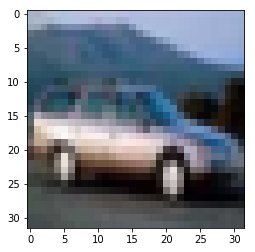

In [17]:
plt.imshow(X[4])

## Supporting Functions to Rearrange Data

### Encode Labels into One-Hot Format

In [46]:
def one_hot_encode(vec, vals=10):
    '''
    For use to one-hot encode the 10- possible labels
    '''
    n = len(vec)
    out = np.zeros((n, vals))
    out[range(n), vec] = 1
    return out

## Set Up Image Data: Make it Ready to be Fed into 1st Conv Layer

In [32]:
class CifarHelper():
    
    def __init__(self):
        self.i = 0
        
        self.all_train_batches = [data_batch1,data_batch2,data_batch3,data_batch4,data_batch5]
        self.test_batch = [test_batch]
        
        self.training_images = None
        self.training_labels = None
        
        self.test_images = None
        self.test_labels = None
    
    def set_up_images(self):
        
        print("Setting Up Training Images and Labels")
        
        self.training_images = np.vstack([d[b"data"] for d in self.all_train_batches])
        train_len = len(self.training_images)
        
        self.training_images = self.training_images.reshape(train_len,3,32,32).transpose(0,2,3,1)/255
        self.training_labels = one_hot_encode(np.hstack([d[b"labels"] for d in self.all_train_batches]), 10)
        
        print("Setting Up Test Images and Labels")
        
        self.test_images = np.vstack([d[b"data"] for d in self.test_batch])
        test_len = len(self.test_images)
        
        self.test_images = self.test_images.reshape(test_len,3,32,32).transpose(0,2,3,1)/255
        self.test_labels = one_hot_encode(np.hstack([d[b"labels"] for d in self.test_batch]), 10)

        
    def next_batch(self, batch_size):
        x = self.training_images[self.i:self.i+batch_size].reshape(100,32,32,3)
        y = self.training_labels[self.i:self.i+batch_size]
        self.i = (self.i + batch_size) % len(self.training_images)
        return x, y

## Set up image data: Calling CifarHelper.set_up_images()

In [33]:
# Before Your tf.Session run these two lines
ch = CifarHelper()
ch.set_up_images()

# During your session to grab the next batch use this line
# (Just like we did for mnist.train.next_batch)
# batch = ch.next_batch(100)

Setting Up Training Images and Labels
Setting Up Test Images and Labels


## Define Supporting Functions to Build, Train, and Test CNN Model

In [81]:
def initialize_weights(filter_shape):
    init_random_dist = tf.truncated_normal(filter_shape,stddev=0.1)
    return (tf.Variable(init_random_dist))

In [82]:
def initialize_bias(bias_shape):
    initial_bias_vals = tf.constant(0.1,shape=bias_shape)
    return (tf.Variable(initial_bias_vals))

In [83]:
def create_convolution_layer_and_compute_dot_product(inputs, filter_shape):
    filter_initialized_with_weights = initialize_weights(filter_shape)
    conv_layer_outputs = tf.nn.conv2d(inputs,filter_initialized_with_weights, strides=[1,1,1,1],padding ='SAME')
    return (conv_layer_outputs)

In [84]:
def create_relu_layer_and_compute_dot_product_plus_b(inputs, filter_shape):
    b = initialize_bias([filter_shape[3]])
    relu_layer_outputs = tf.nn.relu(inputs+b)
    return (relu_layer_outputs)

In [85]:
def create_max_pool2by2_and_reduce_spatial_size(inputs):
    pooling_layer_outputs = tf.nn.max_pool(inputs, ksize=[1,2,2,1],strides = [1,2,2,1],padding='SAME')
    return (pooling_layer_outputs)

In [86]:
def create_fully_connected_layer_and_compute_dotproduct_plus_bias(inputs, output_size):
    input_size = int(inputs.get_shape()[1])
    W = initialize_weights([input_size, output_size])
    b = initialize_bias([output_size])
    fc_xW_plus_bias_outputs=tf.matmul(inputs,W)+b
    return (fc_xW_plus_bias_outputs)

# PHASE I: Build Convolutional Neural Network

In [87]:
import tensorflow as tf

## Create Placeholders for Inputs and Labels: x and y_true

In [88]:
# PLACEHOLDER

# Create a placeholder for the inputs data: x
# x: a 2D array
# x: a placeholder that can hold any number of rows/record

x = tf.placeholder(tf.float32, shape=[None, 32, 32, 3])

In [89]:
# PLACEHOLDER

# Create a placeholder for the labels of the inputs data: y_true
# y_true: a 2D array
# y_true: Can hold any number of rows/records

y_true = tf.placeholder(tf.float32, [None, 10])

## Reshape the Input Placeholder x: NOT NEED TO RESHAPE DATA HERE

In [56]:
# DO NOTHING -- DON'T NEED TO RESHAPE - DATA IS ALREADY IN GOOD SHAPE TO BE FED INTO 1ST CONVOLUTION LAYER

## Create 1st Convolution Layer and so on .............

Creating first convolution layer, ReLu layer and performing computation

In [91]:
#
conv_layer_1_outputs=create_convolution_layer_and_compute_dot_product(x,filter_shape=[4,4,3,32])
conv_relu_layer_1_output=create_relu_layer_and_compute_dot_product_plus_b(conv_layer_1_outputs,filter_shape=[4,4,3,32])

Creating first pooling layer and reducing spatial size

In [92]:
#
pooling_layer_1_outputs = create_max_pool2by2_and_reduce_spatial_size(conv_relu_layer_1_output)

creating second convolution layer, ReLu layer and performing computation

In [93]:
#
conv_layer_2_outputs=create_convolution_layer_and_compute_dot_product(pooling_layer_1_outputs,filter_shape=[4,4,32,64])
conv_relu_layer_2_output=create_relu_layer_and_compute_dot_product_plus_b(conv_layer_2_outputs,filter_shape=[4,4,32,64])

Creating second pooling layer and reducing spatial size

In [94]:
#
pooling_layer_2_outputs = create_max_pool2by2_and_reduce_spatial_size(conv_relu_layer_2_output)

Create Flattened Layer

In [95]:
#
poolig_layer_2_outputs_flat = tf.reshape(pooling_layer_2_outputs, [-1,8*8*64])

creating first fully connected, Relu layer and output data to dropout layer

In [96]:
#
fc_layer_1_outputs = create_fully_connected_layer_and_compute_dotproduct_plus_bias(poolig_layer_2_outputs_flat, output_size=1024)
fc_relu_layer_1_outputs = tf.nn.relu(fc_layer_1_outputs)

creating dropout layer and droping out a fractions of output randomly

In [97]:
#
hold_prob = tf.placeholder(tf.float32)
fc_dropout_outputs = tf.nn.dropout(fc_relu_layer_1_outputs, keep_prob=hold_prob)

Final Output

In [98]:
#
y_pred = create_fully_connected_layer_and_compute_dotproduct_plus_bias(fc_dropout_outputs,output_size=10)

Defining loss function and calculating softmax cross entropy

In [99]:
#
softmax_cross_entropy_loss = tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_true,logits=y_pred)
cross_entropy_mean = tf.reduce_mean(softmax_cross_entropy_loss)

Creating optimizer to optimize CNN model and set learning rate

In [100]:
#
optimizer = tf.train.AdamOptimizer(learning_rate=0.001)

Creating a Trainer and Train, test CNN DL model on CIFAR dataset

In [102]:
#
cnn_trainer=optimizer.minimize(cross_entropy_mean)
vars_initializer = tf.global_variables_initializer()

# PHASE II: Train and Test CNN Model on CIFAR-10 Dataset

Setting the steps

In [103]:
steps=5000

In [107]:
accuracies=[]
with tf.Session() as sess:
    sess.run(vars_initializer)
    for i in range(steps):
        batch = ch.next_batch(100)
        sess.run(cnn_trainer,feed_dict = {x:batch[0], y_true:batch[1],hold_prob:0.5})
        if i%100==0:
            print("ON STEP :{}".format(i))
            matches = tf.equal(tf.argmax(y_pred,1),tf.argmax(y_true,1))
            acc = tf.reduce_mean(tf.cast(matches,tf.float32))
            test_accuracy = sess.run(acc,feed_dict={x:ch.test_images,y_true:ch.test_labels,hold_prob:1.0})
            print(test_accuracy)
            accuracies.append(test_accuracy)
    print('Check Accuracy!')

ON STEP :0
0.111
ON STEP :100
0.4277
ON STEP :200
0.4835
ON STEP :300
0.5216
ON STEP :400
0.5498
ON STEP :500
0.5734
ON STEP :600
0.5771
ON STEP :700
0.5832
ON STEP :800
0.6025
ON STEP :900
0.6181
ON STEP :1000
0.6245
ON STEP :1100
0.6224
ON STEP :1200
0.6231
ON STEP :1300
0.6325
ON STEP :1400
0.6507
ON STEP :1500
0.6511
ON STEP :1600
0.6503
ON STEP :1700
0.6502
ON STEP :1800
0.6687
ON STEP :1900
0.6687
ON STEP :2000
0.6592
ON STEP :2100
0.6722
ON STEP :2200
0.6692
ON STEP :2300
0.6709
ON STEP :2400
0.6756
ON STEP :2500
0.6751
ON STEP :2600
0.6689
ON STEP :2700
0.6842
ON STEP :2800
0.6642
ON STEP :2900
0.6881
ON STEP :3000
0.686
ON STEP :3100
0.6707
ON STEP :3200
0.6892
ON STEP :3300
0.6877
ON STEP :3400
0.6926
ON STEP :3500
0.6817
ON STEP :3600
0.6755
ON STEP :3700
0.6761
ON STEP :3800
0.6976
ON STEP :3900
0.6968
ON STEP :4000
0.6927
ON STEP :4100
0.6897
ON STEP :4200
0.684
ON STEP :4300
0.6968
ON STEP :4400
0.6971
ON STEP :4500
0.6935
ON STEP :4600
0.701
ON STEP :4700
0.6951
ON STEP 

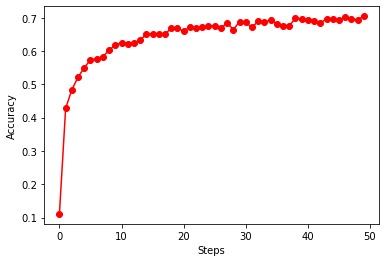

In [109]:
import matplotlib.pyplot as plt
plt.plot(accuracies,color='red', marker='o')
plt.xlabel('Steps')
plt.ylabel('Accuracy')
plt.show()
